In [61]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [62]:
archivos = glob.glob('dataset/*.csv') #agrupo todos los csv
archivos_ordenados = sorted(archivos, key=lambda x: x.split('_')[3]) #ordeno por YYYMM de forma asc

In [63]:
dataframes = []
for archivo in archivos_ordenados: # junto todos los csv
    df = pd.read_csv(archivo, header=None, sep=';')
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

nombres_columnas = ['ID', 'Date', 'Consumo', 'Flag', 'Muestra', 'Nombre_Interruptor']
data.columns = nombres_columnas + list(range(len(nombres_columnas), len(data.columns)))

In [64]:
def remove_timezone(date_str):
    return re.sub(r'\s*[-+]\d{4}', '', date_str)
data["Date"] = data["Date"].apply(remove_timezone)
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d %H:%M:%S")

In [65]:
valores_faltantes = data.isnull().sum()
proporcion_faltantes = valores_faltantes / len(data) * 100
print("Valores faltantes por columna:")
print(proporcion_faltantes)

# Identificar las columnas con valores faltantes
columnas_con_faltantes = valores_faltantes[valores_faltantes > 0].index.tolist()
print("\nColumnas con valores faltantes:")
print(columnas_con_faltantes)

# Evaluar el impacto de los valores faltantes en tu análisis
# Aquí puedes realizar análisis específicos para cada columna con valores faltantes y determinar su importancia

# Considerar estrategias para manejar los valores faltantes
# Por ejemplo, puedes imputar los valores faltantes con la media o la mediana de la columna, eliminar filas con valores faltantes, etc.
# Aquí hay un ejemplo de imputación de valores faltantes con la media de la columna "columna_con_faltantes":
datos_imputados = data.copy()
for columna in columnas_con_faltantes:
    media = data[columna].mean()
    datos_imputados[columna].fillna(media, inplace=True)

Valores faltantes por columna:
ID                    0.0
Date                  0.0
Consumo               0.0
Flag                  0.0
Muestra               0.0
Nombre_Interruptor    0.0
dtype: float64

Columnas con valores faltantes:
[]


In [66]:
data.head(10)

,ID,Date,Consumo,Flag,Muestra,Nombre_Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL 110 H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN 110 HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN 110 H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME 110 H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME 110 H3 P
5,397712211,2017-02-28 15:00:00,74.248916,1,4,LOSALME 110 H4 P
6,400203211,2017-02-28 15:00:00,30.345499,1,4,LOSALME 110 H2 P
7,433388211,2017-02-28 15:00:00,158.178446,1,4,CHENA 110 H1 P
8,393655211,2017-02-28 15:00:00,109.541742,1,4,BUIN 110 H1 P
9,433398211,2017-02-28 15:00:00,129.607846,1,4,CHENA 110 H2 P


In [67]:
split_data = data['Nombre_Interruptor'].str.split()

data['Barra'] = split_data.str[0]
data['Subestacion'] = split_data.str[1].str.join(' ')
data['Interruptor'] = split_data.str[2:].str.join(' ')

data.drop(columns=['Nombre_Interruptor'], inplace=True)

In [68]:
data

,ID,Date,Consumo,Flag,Muestra,Barra,Subestacion,Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL,1 1 0,H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN,1 1 0,HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN,1 1 0,H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME,1 1 0,H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME,1 1 0,H3 P
...,...,...,...,...,...,...,...,...
2242963,387377211,2023-06-27 23:00:00,9.554752,1,4,FLORIDA,1 1 0,H3 P
2242964,387401211,2023-06-27 23:00:00,-24.972685,1,4,FLORIDA,1 1 0,H4 P
2242965,392490211,2023-06-27 23:00:00,-39.438634,1,4,FLORIDA,1 1 0,H8 P
2242966,392509211,2023-06-27 23:00:00,37.972639,1,4,FLORIDA,1 1 0,H7 P


In [69]:
# Verificar la consistencia de los datos en cada columna
consistencia_columnas = data.apply(lambda x: x.nunique())
print("Número de valores únicos por columna:")
print(consistencia_columnas)


Número de valores únicos por columna:
ID                  39
Date             55296
Consumo        1970970
Flag                 3
Muestra              5
Barra                7
Subestacion          1
Interruptor         12
dtype: int64


In [70]:
# Realizar análisis estadístico para identificar datos atípicos
analisis_estadistico = data.describe()
print("Análisis estadístico de los datos:")
print(analisis_estadistico)


Análisis estadístico de los datos:
                 ID                           Date       Consumo  \
count  2.242968e+06                        2242968  2.242968e+06   
mean   3.617996e+08  2020-05-25 17:45:27.354291456  3.233541e+01   
min    1.777602e+08            2017-02-28 15:00:00 -5.970000e+02   
25%    2.255402e+08            2018-10-21 05:45:00 -3.062436e+00   
50%    3.925612e+08            2020-06-11 06:30:00  4.379763e+01   
75%    4.333882e+08            2022-02-05 23:15:00  8.145555e+01   
max    8.546412e+08            2023-06-27 23:00:00  3.199903e+02   
std    1.257530e+08                            NaN  7.411118e+01   

               Flag       Muestra  
count  2.242968e+06  2.242968e+06  
mean   9.889330e-01  3.940358e+00  
min    0.000000e+00  0.000000e+00  
25%    1.000000e+00  4.000000e+00  
50%    1.000000e+00  4.000000e+00  
75%    1.000000e+00  4.000000e+00  
max    3.300000e+01  4.000000e+00  
std    5.571145e-01  4.551701e-01  


In [71]:
valor_minimo = data['Consumo'].min()
print(f'Valor Mínimo: {valor_minimo}')
valor_maximo = data['Consumo'].max()
print(f'Valor Máximo: {valor_maximo}')
columna_especifica = data['Consumo']
rangos_validos = (data['Consumo'] >= valor_minimo) & (data['Consumo'] <= valor_maximo)
datos_inconsistentes = data[~rangos_validos]
print(f'Datos columna Consumo:')
print(columna_especifica)
print(f'Datos inconsistentes: {datos_inconsistentes}')
print('\n')

Valor Mínimo: -597.0
Valor Máximo: 319.990285
Datos columna Consumo:
0          -28.206767
1         -236.467353
2          126.075465
3           81.017303
4           69.876691
              ...    
2242963      9.554752
2242964    -24.972685
2242965    -39.438634
2242966     37.972639
2242967     -0.113527
Name: Consumo, Length: 2242968, dtype: float64
Datos inconsistentes: Empty DataFrame
Columns: [ID, Date, Consumo, Flag, Muestra, Barra, Subestacion, Interruptor]
Index: []




In [72]:
consumo = data.groupby(['Barra', 'Date'])['Consumo'].sum().reset_index()
#consumo=consumo.set_index("Fecha_Hora")

In [73]:
consumo

,Barra,Date,Consumo
0,AJAHUEL,2017-02-28 15:00:00,179.705306
1,AJAHUEL,2017-02-28 16:00:00,184.789336
2,AJAHUEL,2017-02-28 17:00:00,187.619336
3,AJAHUEL,2017-02-28 18:00:00,182.389885
4,AJAHUEL,2017-02-28 19:00:00,173.051792
...,...,...,...
387067,LOSALME,2023-06-27 19:00:00,216.470914
387068,LOSALME,2023-06-27 20:00:00,213.860067
387069,LOSALME,2023-06-27 21:00:00,209.034960
387070,LOSALME,2023-06-27 22:00:00,199.870564


In [74]:
# Calcular el rango intercuartílico (IQR)
Q1 = consumo['Consumo'].quantile(0.25)
Q3 = consumo['Consumo'].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites inferior y superior para identificar outliers
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filtrar el dataset para excluir outliers
without_me = consumo[(consumo['Consumo'] >= lower_bound) & (consumo['Consumo'] <= upper_bound)]


In [75]:
without_me.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384738 entries, 0 to 387071
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Barra    384738 non-null  object        
 1   Date     384738 non-null  datetime64[ns]
 2   Consumo  384738 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.7+ MB


In [76]:
entrenamiento=consumo.query("Date.dt.year>2017 and Date.dt.year<2022")
validacion=consumo.query("Date.dt.year==2022")

In [77]:
#sin outlayers
train_out=without_me.query("Date.dt.year>2017 and Date.dt.year<2022")
test_out=without_me.query("Date.dt.year==2022")

In [78]:
entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train=entrenamiento.set_index("Date")

validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test=validacion.set_index("Date")

<ipython-input-78-0bd81b097536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-78-0bd81b097536>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")


In [79]:
ds_train

,Barra,Consumo
Date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069
...,...,...
2021-12-31 19:00:00,LOSALME,168.644175
2021-12-31 20:00:00,LOSALME,171.593959
2021-12-31 21:00:00,LOSALME,160.167061


In [80]:
#sin outlayers
train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train_out=train_out.set_index("Date")

test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test_out=test_out.set_index("Date")

<ipython-input-80-8cca01920b76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-80-8cca01920b76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")


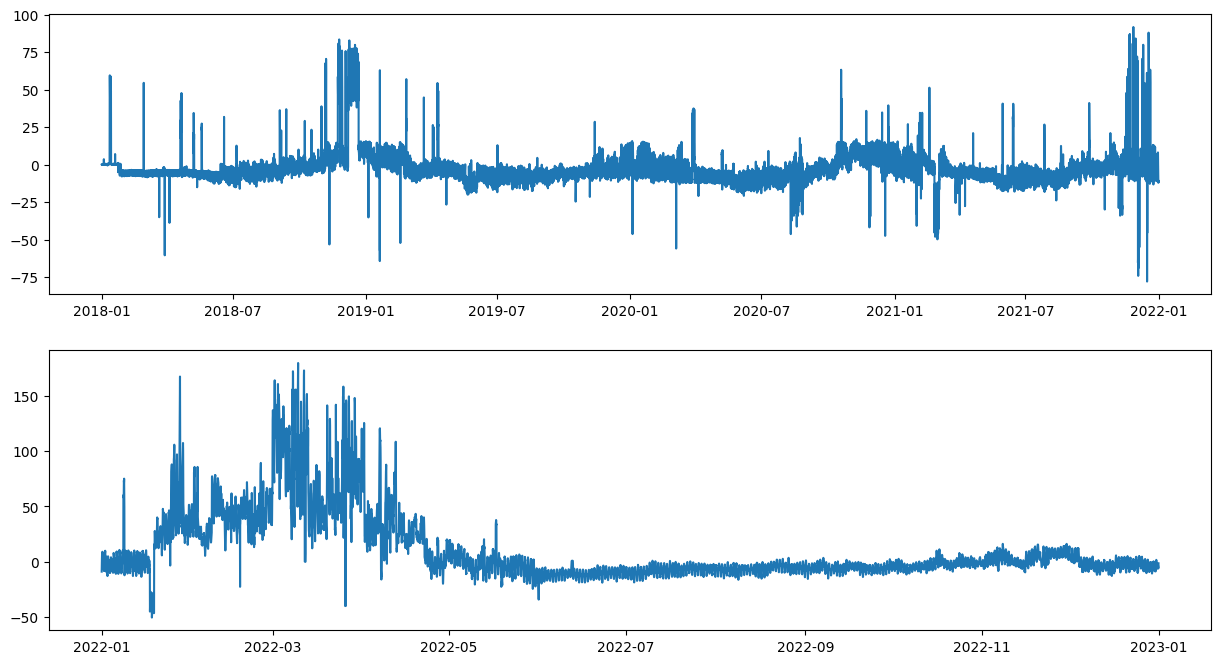

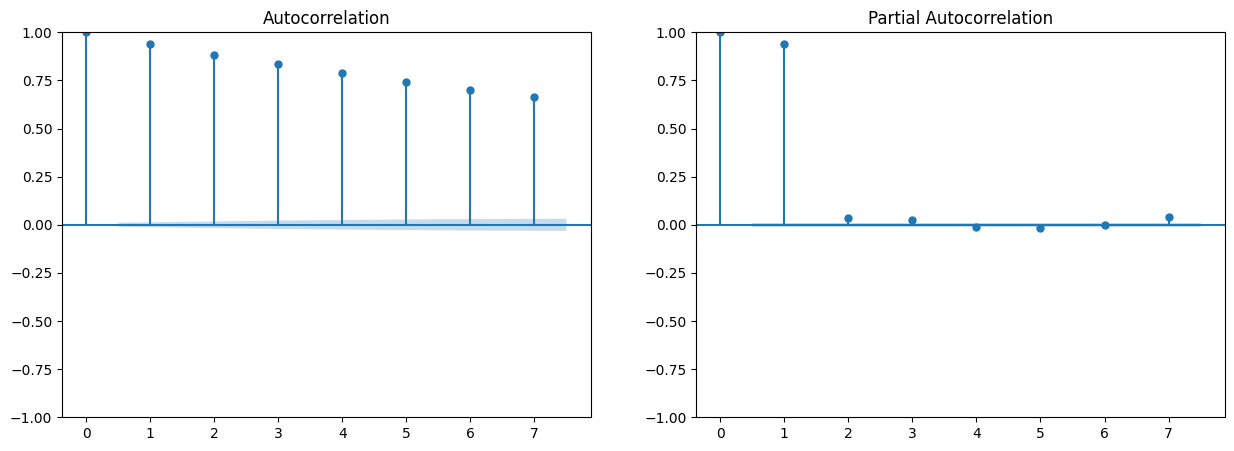

In [81]:
subestacion='FLORIDA'
filtro="Barra=='{0}'".format(subestacion)
y_florida=ds_train.query(filtro)["Consumo"]
x_florida=ds_train.query(filtro).index
yt_florida=ds_test.query(filtro)["Consumo"]
xt_florida=ds_test.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_florida,y_florida);
axes[1].plot(xt_florida,yt_florida);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_florida,lags=7,ax=axes[0]);
plot_pacf(y_florida,lags=7,method="ywm",ax=axes[1]);


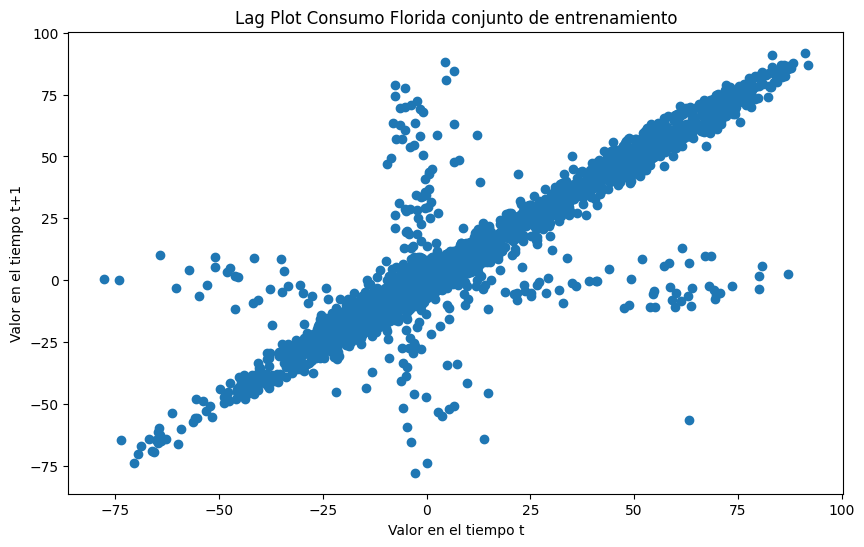

In [82]:
plt.figure(figsize=(10, 6))
lag_plot(y_florida, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo Florida conjunto de entrenamiento')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

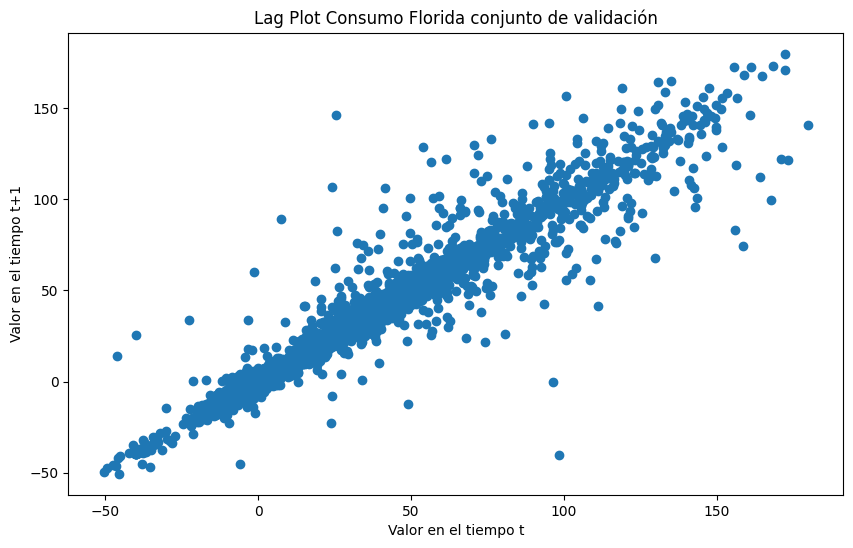

In [83]:
plt.figure(figsize=(10, 6))
lag_plot(yt_florida, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo Florida conjunto de validación')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

<Axes: xlabel='Hora', ylabel='Consumo'>

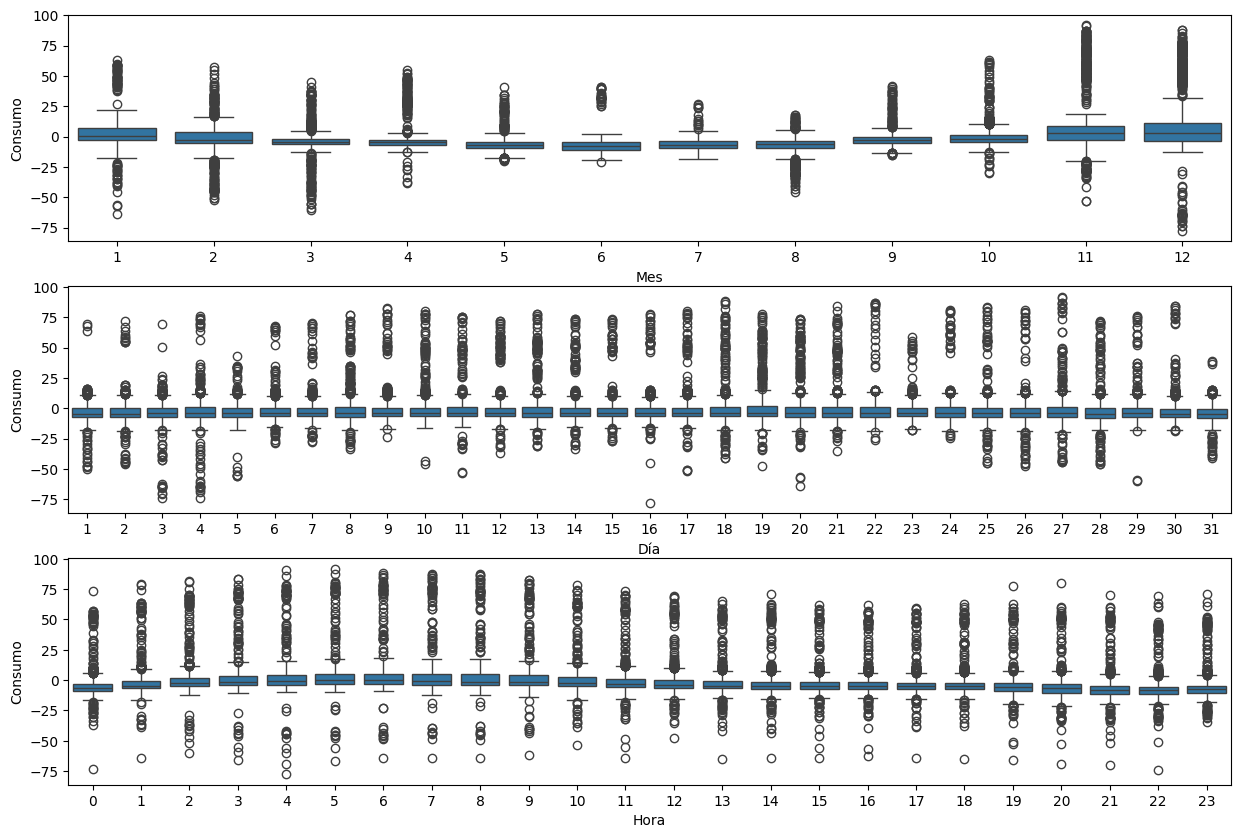

In [84]:
data_florida=pd.DataFrame()
data_florida["Consumo"]=y_florida
data_florida["Date"]=y_florida.index
data_florida["Día"]=data_florida["Date"].dt.day
data_florida["Hora"]=data_florida["Date"].dt.hour
data_florida["Mes"]=data_florida["Date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="Mes", y="Consumo", data=data_florida, ax=axes[0])
sns.boxplot(x="Día", y="Consumo", data=data_florida, ax=axes[1])
sns.boxplot(x="Hora", y="Consumo", data=data_florida, ax=axes[2])

In [85]:
data_florida["Año"]=data_florida["Date"].dt.year
data_florida

,Consumo,Date,Día,Hora,Mes,Año
Date,,,,,,
2018-01-01 00:00:00,0.219616,2018-01-01 00:00:00,1,0,1,2018
2018-01-01 01:00:00,0.102980,2018-01-01 01:00:00,1,1,1,2018
2018-01-01 02:00:00,0.099852,2018-01-01 02:00:00,1,2,1,2018
2018-01-01 03:00:00,0.068052,2018-01-01 03:00:00,1,3,1,2018
2018-01-01 04:00:00,0.031040,2018-01-01 04:00:00,1,4,1,2018
...,...,...,...,...,...,...
2021-12-31 19:00:00,-11.944263,2021-12-31 19:00:00,31,19,12,2021
2021-12-31 20:00:00,-10.195266,2021-12-31 20:00:00,31,20,12,2021
2021-12-31 21:00:00,-10.473266,2021-12-31 21:00:00,31,21,12,2021


In [86]:
data_ys_florida=data_florida[["Año","Mes","Día","Consumo"]].groupby(["Año","Mes","Día"]).agg("mean")
data_ys_florida.to_csv("data_ys_florida.csv")

In [87]:
data_ys_florida

Consumo
Año  Mes Día          
2018 1   1    0.112180
         2    0.299821
         3    0.394467
         4    0.847925
         5    0.443929
...                ...
2021 12  27   0.703512
         28  -1.768329
         29  -4.210729
         30  -3.109258
         31  -3.557219

[1461 rows x 1 columns]

In [88]:
ys_florida=[]
xs_florida=[]
archivo=open("data_ys_florida.csv")
archivo.readline()
for linea in archivo:
    linea=linea.strip().split(",")
    ys_florida.append(float(linea[3]))
    fecha=str(linea[0])+"-"+str(linea[1]).zfill(2)+"-"+str(linea[2]).zfill(2)
    xs_florida.append(datetime.strptime(fecha,"%Y-%m-%d"))

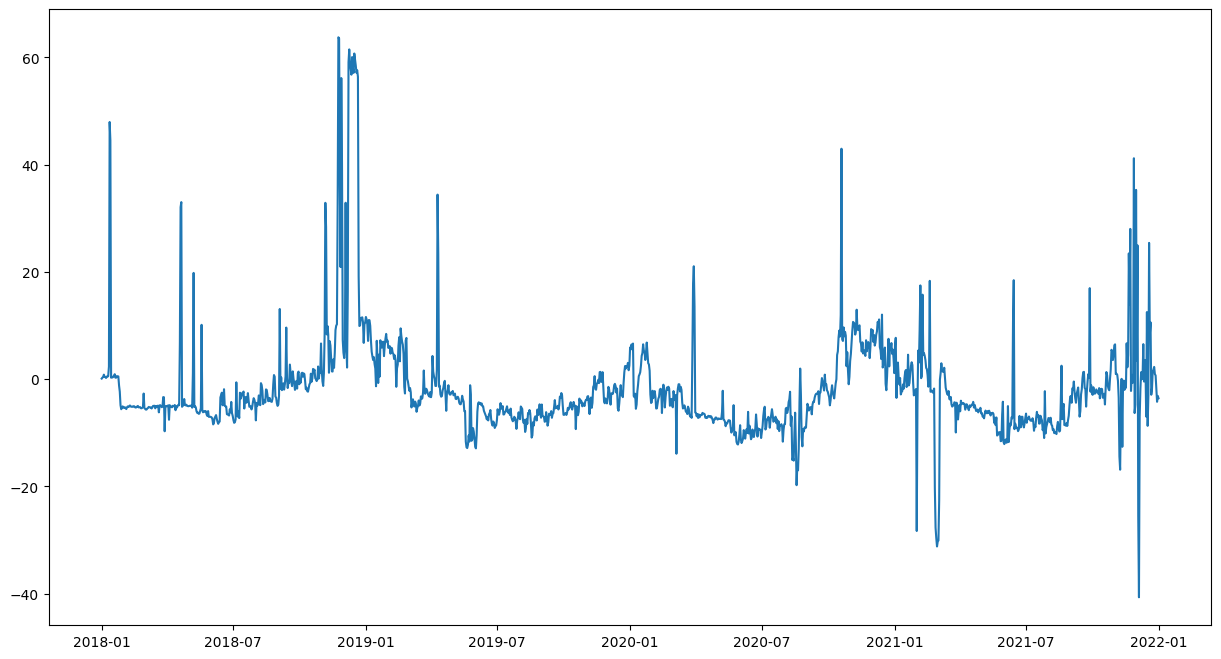

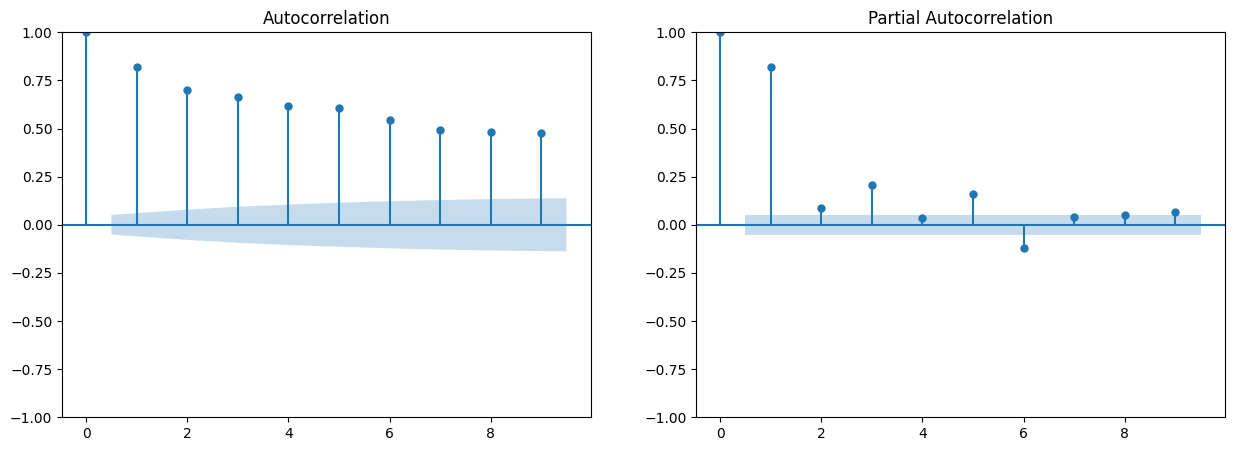

In [89]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_florida,ys_florida);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ys_florida,lags=9,ax=axes[0]);
plot_pacf(ys_florida,lags=9,method="ywm",ax=axes[1]);

In [90]:
result = kpss(ys_florida)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.33855776314389957
p-value: 0.1
La serie es estacionaria


<ipython-input-90-7635d02b7afe>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(ys_florida)


**Modelo ARIMA**

In [158]:
modelo_florida_d=ARIMA(ys_florida,order=(1,0,1))
m_ad1=modelo_florida_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ysp_florida=m_ad1.predict()
mape=mean_absolute_percentage_error(ys_florida,ysp_florida)
print("MAPE",mape)

MSE 31.074102480050414
AIC 9175.753260042839
MAPE 1.2763551076870367


In [137]:
"""
#sin outlayers
modelo_florida_d_out=ARIMA(ys_florida_out,order=(8,0,8))
m_ad1_out=modelo_florida_d_out.fit()
print("MSE",m_ad1_out.mse)
print("AIC",m_ad1_out.aic)
ysp_florida_out=m_ad1_out.predict()
mape_out=mean_absolute_percentage_error(ys_florida_out,ysp_florida_out)
print("MAPE",mape_out)
"""

'\n#sin outlayers\nmodelo_florida_d_out=ARIMA(ys_florida_out,order=(8,0,8))\nm_ad1_out=modelo_florida_d_out.fit()\nprint("MSE",m_ad1_out.mse)\nprint("AIC",m_ad1_out.aic)\nysp_florida_out=m_ad1_out.predict()\nmape_out=mean_absolute_percentage_error(ys_florida_out,ysp_florida_out)\nprint("MAPE",mape_out)\n'

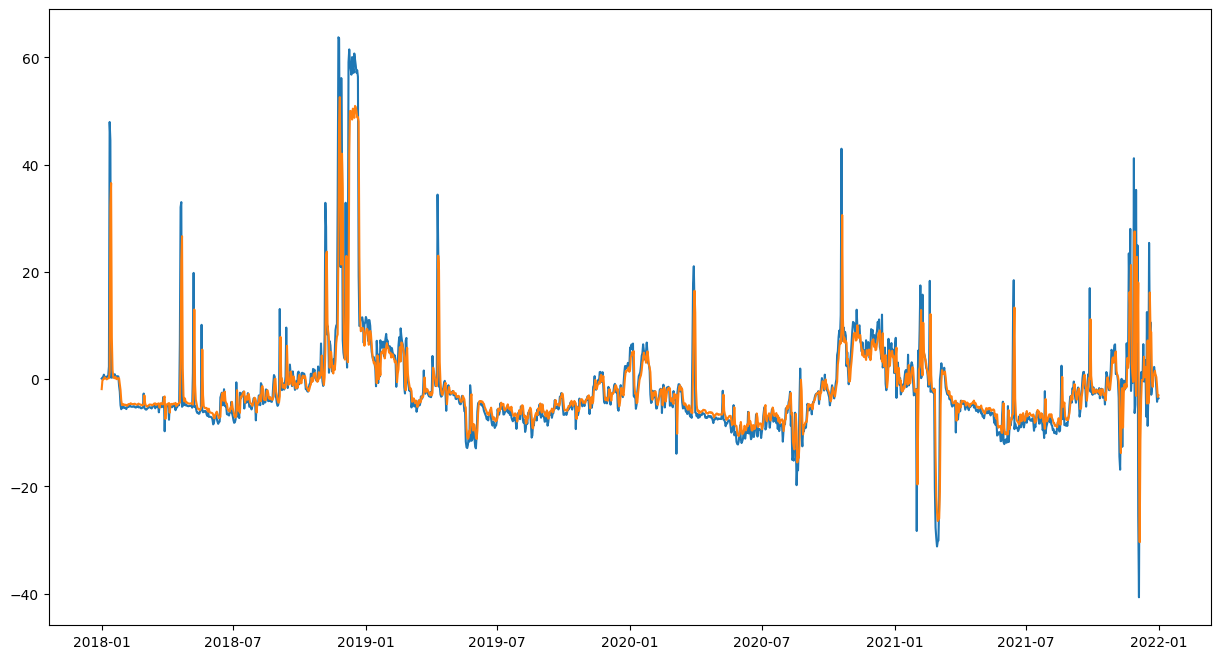

In [159]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_florida,ys_florida,xs_florida,ysp_florida);

In [139]:
"""
#sin outlayers
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_florida_out,ys_florida_out,xs_florida_out,ysp_florida_out);
"""

'\n#sin outlayers\nfig, axes = plt.subplots(1,1)\nfig.set_size_inches(15, 8)\naxes.plot(xs_florida_out,ys_florida_out,xs_florida_out,ysp_florida_out);\n'

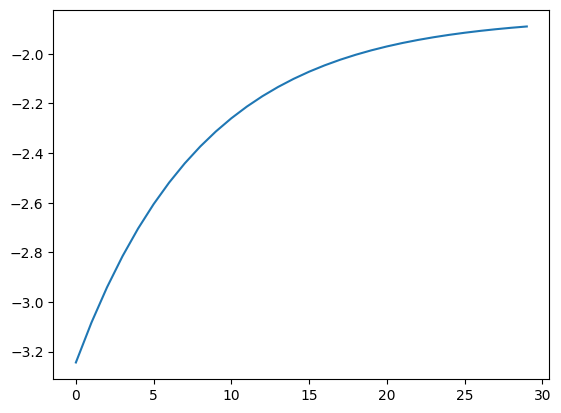

In [160]:
m1_y1_p = m_ad1.get_forecast(steps=30)
m1_y1_ci = m_ad1.conf_int(0.05)
plt.plot(m1_y1_p.predicted_mean)

In [141]:
"""
#sin outlayers
m1_y1_p_out = m_ad1_out.get_forecast(steps=30)
m1_y1_ci_out = m_ad1_out.conf_int(0.05)
plt.plot(m1_y1_p_out.predicted_mean)
"""

'\n#sin outlayers\nm1_y1_p_out = m_ad1_out.get_forecast(steps=30)\nm1_y1_ci_out = m_ad1_out.conf_int(0.05)\nplt.plot(m1_y1_p_out.predicted_mean)\n'

**Modelo Redes Neuronales RNN**

In [199]:
yw_florida=[]
yt_florida=[]
window=8
for i in range(0,len(ys_florida)):
    if i+window < len(ys_florida):
        row=[]
        for j in range(window):
            row.append(ys_florida[i+j])
        yw_florida.append(row)
        yt_florida.append(ys_florida[i+window])
    else:
        break
print(len(yw_florida))

1453


In [200]:
"""
#sin outlayers
yw_florida_out=[]
yt_florida_out=[]
window=8
for i in range(0,len(ys_florida_out)):
    if i+window < len(ys_florida_out):
        row=[]
        for j in range(window):
            row.append(ys_florida_out[i+j])
        yw_florida_out.append(row)
        yt_florida_out.append(ys_florida_out[i+window])
    else:
        break
print(len(yw_florida_out))
"""

'\n#sin outlayers\nyw_florida_out=[]\nyt_florida_out=[]\nwindow=8\nfor i in range(0,len(ys_florida_out)):\n    if i+window < len(ys_florida_out):\n        row=[]\n        for j in range(window):\n            row.append(ys_florida_out[i+j])\n        yw_florida_out.append(row)\n        yt_florida_out.append(ys_florida_out[i+window])\n    else:\n        break\nprint(len(yw_florida_out))\n'

In [201]:
yw_florida=np.asarray(yw_florida)
yt_florida=np.asarray(yt_florida)

In [202]:
"""
#sin outlayers
yw_florida_out=np.asarray(yw_florida_out)
yt_florida_out=np.asarray(yt_florida_out)
"""

'\n#sin outlayers\nyw_florida_out=np.asarray(yw_florida_out)\nyt_florida_out=np.asarray(yt_florida_out)\n'

In [203]:
import tensorflow as tf
from datetime import datetime
from keras.layers import SimpleRNN, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

In [204]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [205]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mape', patience=50, restore_best_weights=True)

model_florida = Sequential()
model_florida.add(Input(name="serie",shape=(8,1)))
model_florida.add(SimpleRNN(300))
model_florida.add(Dense(130))
model_florida.add(Dense(1, activation='linear'))
model_florida.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 300)               90600     
                                                                 
 dense_28 (Dense)            (None, 130)               39130     
                                                                 
 dense_29 (Dense)            (None, 1)                 131       
                                                                 
Total params: 129861 (507.27 KB)
Trainable params: 129861 (507.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [206]:
#Sin outliyers
model_florida_out = Sequential()
model_florida_out.add(Input(name="serie",shape=(8,1)))
model_florida_out.add(SimpleRNN(300))
model_florida_out.add(Dense(128))
model_florida_out.add(Dense(1, activation='linear'))
model_florida_out.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 300)               90600     
                                                                 
 dense_30 (Dense)            (None, 128)               38528     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 129257 (504.91 KB)
Trainable params: 129257 (504.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [207]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_florida.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_florida.fit(yw_florida, yt_florida, batch_size=300, epochs=500, verbose=1, callbacks=callbacks)
model_florida.save(log_dir + '/model_{0}.keras'.format(tag))

Epoch 1/500
5/5 [==============================] - 2s 98ms/step - loss: 64.5857 - mse: 64.5857 - mae: 4.2871 - mape: 155.3663
Epoch 2/500
5/5 [==============================] - 0s 70ms/step - loss: 44.0688 - mse: 44.0688 - mae: 3.0565 - mape: 236.5063
Epoch 3/500
5/5 [==============================] - 0s 79ms/step - loss: 40.3017 - mse: 40.3017 - mae: 3.1237 - mape: 174.1787
Epoch 4/500
5/5 [==============================] - 0s 78ms/step - loss: 39.5882 - mse: 39.5882 - mae: 3.0170 - mape: 171.8658
Epoch 5/500
5/5 [==============================] - 0s 78ms/step - loss: 37.3052 - mse: 37.3052 - mae: 2.8441 - mape: 162.6906
Epoch 6/500
5/5 [==============================] - 0s 77ms/step - loss: 35.3530 - mse: 35.3530 - mae: 2.7231 - mape: 140.5362
Epoch 7/500
5/5 [==============================] - 0s 77ms/step - loss: 34.4342 - mse: 34.4342 - mae: 2.6588 - mape: 158.9187
Epoch 8/500
5/5 [==============================] - 0s 83ms/step - loss: 33.4598 - mse: 33.4598 - mae: 2.6342 - mape: 1

46/46 [==============================] - 0s 3ms/step


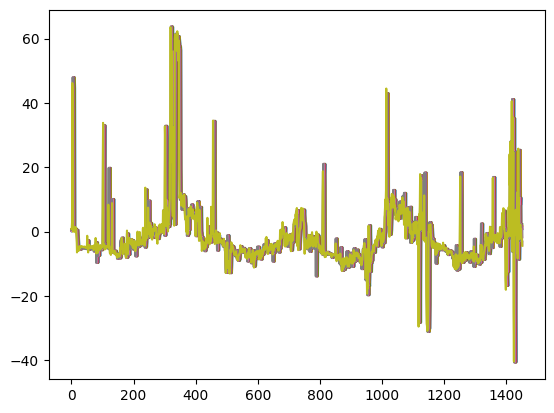

In [208]:
xw_florida=[i for i in range(len(yw_florida))]
yp_florida=model_florida.predict(yw_florida)
plt.plot(xw_florida,yw_florida,xw_florida,yp_florida)

1/1 [==============================] - 0s 19ms/step
-4.416537
1/1 [==============================] - 0s 22ms/step
-17.731562
1/1 [==============================] - 0s 18ms/step
-13.422103
1/1 [==============================] - 0s 24ms/step
-12.758715
1/1 [==============================] - 0s 21ms/step
-5.7086287
1/1 [==============================] - 0s 23ms/step
-6.176857
1/1 [==============================] - 0s 23ms/step
-5.846874
1/1 [==============================] - 0s 26ms/step
-10.427803
1/1 [==============================] - 0s 20ms/step
-9.267988
1/1 [==============================] - 0s 21ms/step
-9.01018
1/1 [==============================] - 0s 22ms/step
-7.363061
1/1 [==============================] - 0s 24ms/step
-7.841279
1/1 [==============================] - 0s 22ms/step
-7.803691
1/1 [==============================] - 0s 23ms/step
-7.2747746
1/1 [==============================] - 0s 21ms/step
-6.43212
1/1 [==============================] - 0s 21ms/step
-6.1438227
1/1

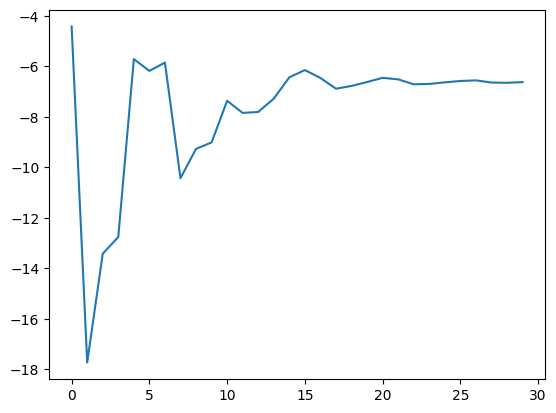

In [209]:
ultimo_florida=list(yw_florida[-1].copy())
forecasts=[]
for i in range(30):
    data_florida=np.array(np.asarray([ultimo_florida]))
    forecast=model_florida.predict(data_florida)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_florida.pop(0)
    ultimo_florida.append(valor)
plt.plot(forecasts)

In [194]:
#entrega de datos desordenados
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_florida.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_florida.fit(yw_florida, yt_florida, batch_size=300, epochs=500,shuffle=True,verbose=1,callbacks=callbacks)
model_florida.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/500
5/5 [==============================] - 1s 48ms/step - loss: 32.2651 - mse: 32.2651 - mae: 3.8092 - mape: 247.3862
Epoch 2/500
5/5 [==============================] - 0s 47ms/step - loss: 26.0603 - mse: 26.0603 - mae: 3.0937 - mape: 209.2513
Epoch 3/500
5/5 [==============================] - 0s 48ms/step - loss: 24.1948 - mse: 24.1948 - mae: 2.8123 - mape: 197.7116
Epoch 4/500
5/5 [==============================] - 0s 46ms/step - loss: 23.4535 - mse: 23.4535 - mae: 2.6449 - mape: 176.5531
Epoch 5/500
5/5 [==============================] - 0s 48ms/step - loss: 22.2383 - mse: 22.2383 - mae: 2.4360 - mape: 149.2612
Epoch 6/500
5/5 [==============================] - 0s 50ms/step - loss: 21.6427 - mse: 21.6427 - mae: 2.4568 - mape: 176.3480
Epoch 7/500
5/5 [==============================] - 0s 45ms/step - loss: 20.5939 - mse: 20.5939 - mae: 2.3650 - mape: 176.9041
Epoch 8/500
5/5 [==============================] - 0s 50ms/step - loss: 20.0778 - mse: 20.0778 - mae: 2.3093 - mape: 1

46/46 [==============================] - 0s 3ms/step


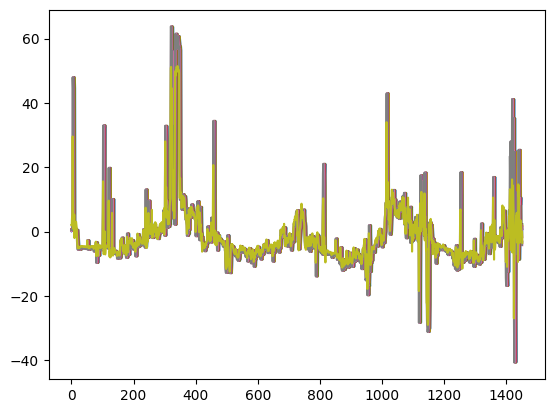

In [195]:
xw_florida=[i for i in range(len(yw_florida))]
yp=model_florida.predict(yw_florida)
plt.plot(xw_florida,yw_florida,xw_florida,yp_florida)

1/1 [==============================] - 0s 109ms/step
-5.033364
1/1 [==============================] - 0s 48ms/step
-17.369959
1/1 [==============================] - 0s 18ms/step
-13.227855
1/1 [==============================] - 0s 18ms/step
-6.09142
1/1 [==============================] - 0s 22ms/step
-2.2053642
1/1 [==============================] - 0s 23ms/step
-4.5119166
1/1 [==============================] - 0s 20ms/step
-10.864171
1/1 [==============================] - 0s 22ms/step
-8.280584
1/1 [==============================] - 0s 119ms/step
-7.07915
1/1 [==============================] - 0s 107ms/step
-6.06923
1/1 [==============================] - 0s 76ms/step
-6.883681
1/1 [==============================] - 0s 19ms/step
-6.915492
1/1 [==============================] - 0s 19ms/step
-6.650544
1/1 [==============================] - 0s 19ms/step
-5.614897
1/1 [==============================] - 0s 21ms/step
-5.890059
1/1 [==============================] - 0s 19ms/step
-6.0839553
1/

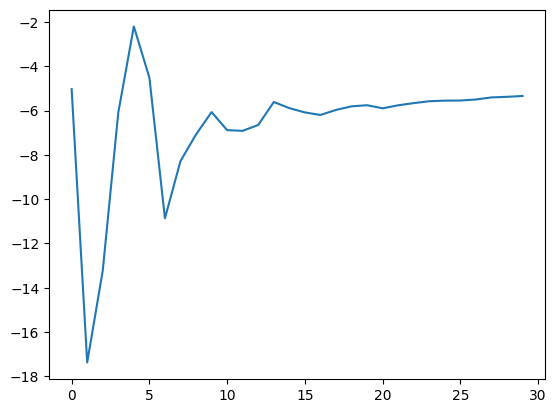

In [196]:
ultimo_florida=list(yw_florida[-1].copy())
forecasts=[]
for i in range(30):
    data_florida=np.array(np.asarray([ultimo_florida]))
    forecast=model_florida.predict(data_florida)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_florida.pop(0)
    ultimo_florida.append(valor)
plt.plot(forecasts)

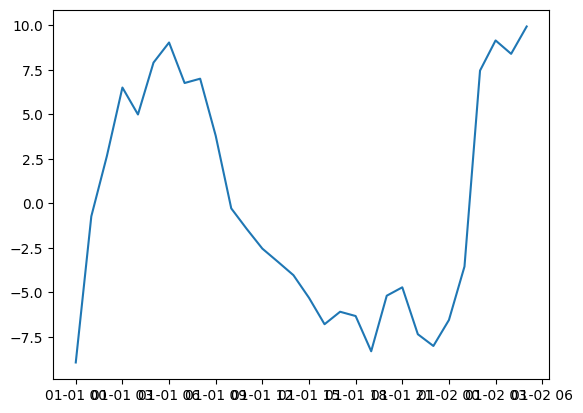

In [197]:
yt_florida=ds_test.query(filtro)["Consumo"]
xt_florida=ds_test.query(filtro).index
plt.plot(xt_florida[:30],yt_florida[:30])

**Modelo Percetron Multicapa**

In [198]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Preparar los datos de entrenamiento
X_train = x_florida.values.reshape(-1, 1)  # Usar la fecha como característica
y_train = y_florida.values.ravel()  # Aplanar y convertir a un arreglo unidimensional

# Crear y entrenar el modelo MLP
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)
model.fit(X_train, y_train)

X_test = yt_florida.values.reshape(-1, 1)  # Usar los datos de 'Consumo' para el conjunto de prueba
predictions = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(yt_florida, predictions)

# Calcular el error absoluto medio
mae = mean_absolute_error(yt_florida, predictions)

# Calcular R^2
r2 = r2_score(yt_florida, predictions)

# Calcular MAPE
mape = np.mean(np.abs((yt_florida - predictions) / yt_florida)) * 100

print(f'Error cuadrático medio: {mse}')
print(f'Error absoluto medio: {mae}')
print(f'R^2: {r2}')

Error cuadrático medio: 1015.1379897454784
Error absoluto medio: 18.389392092956697
R^2: -0.11626235011208319
